<a href="https://colab.research.google.com/github/hucarlos08/Geo-ML-AT/blob/main/Variational_inference_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Selecting the Form of the Variational Posterior

In the realm of Variational Inference (VI), determining the structure of the variational posterior, $q_{\psi}(\mathbf{z}|\mathbf{x})$, is pivotal. The variational posterior is an approximation to the true posterior, $p(\mathbf{z}|\mathbf{x})$, and is parameterized by variational parameters, $\psi$. The strategic choice of this distribution shape can critically impact the efficacy of VI, and herein, we explore a couple of primary strategies employed:

#### 1. **Fixed-Form Variational Inference**

In this approach, the form of the variational posterior is chosen to be of a specific, convenient functional form, such as a multivariate Gaussian distribution. The selection is often driven by computational and mathematical expediency. The Evidence Lower Bound (ELBO) is then optimized by adjusting the parameters $\psi$ of the chosen distribution, typically utilizing gradient-based optimization methods.

- **Advantages**: It offers computational simplicity and efficiency.
- **Drawbacks**: The fixed form might not be a suitable approximation to the true posterior, especially in complex models.

##### Mathematical Expression:

$$q_{\psi}(\mathbf{z}|\mathbf{x}) = \mathscr{N}(\mathbf{z}; \mu_{\psi}(\mathbf{x}), \Sigma_{\psi}(\mathbf{x}))$$

Here, $\mu_{\psi}(\mathbf{x})$ and $\Sigma_{\psi}(\mathbf{x})$ are the mean and covariance, parameterized by $\psi$, that need to be optimized.

#### 2. **Mean Field Assumption**

An alternative strategy involves invoking the "mean field" assumption. This entails assuming that the variational posterior factorizes completely across the latent variables. Mathematically, this is articulated as:

$$ q_{\psi}(\mathbf{z}|\mathbf{x}) = \prod_{i} q_{\psi_i}(z_i|\mathbf{x}) $$

where $\mathbf{z} = \{z_1, z_2, \ldots, z_N\}$ represents all latent variables and $\psi = \{\psi_1, \psi_2, \ldots, \psi_N\}$ encompasses all the variational parameters.

- **Advantages**: It affords flexibility and can handle higher latent variable dimensions.
- **Drawbacks**: The independence assumption might be too restrictive or unrealistic for certain models.

### In Summary

- **Fixed-Form VI**: Select a specific form for $q$ (such as Gaussian) and optimize the ELBO by tuning $\psi$.
- **Mean Field Assumption**: Assumes a fully factorized form for the variational posterior across latent variables and optimizes the ELBO by tuning $\psi$.

Each approach comes with its own merits and limitations, and the choice therein will hinge upon the specific problem at hand and the trade-offs between approximation accuracy and computational complexity.

,y,x,category
0,1.362469,2.162846,0
1,3.078531,1.080777,1
2,12.288447,7.596022,1
3,6.006298,4.652349,0
4,2.712392,1.635190,1


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)


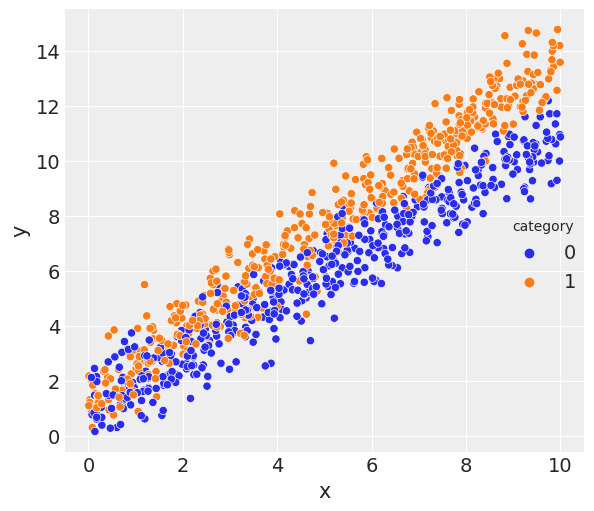

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split
import arviz as az

az.style.use("arviz-darkgrid")


α_0 = 1
α_1 = 1.25

β_0 = 1
β_1 = 1.25

𝜎 = 0.75

n_samples = 1000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)

y = ((1 - category) * α_0 + category * α_1+ ((1 - category) * β_0 + category * β_1) * x + 𝜎 * randn(n_samples))

model_data = pd.DataFrame({'y': y, 'x': x, 'category': category})

train, test = train_test_split(model_data, test_size=0.2, stratify=model_data.category)

display(model_data.head())
_ = sns.relplot(x='x', y='y', hue='category', data=model_data)




In [ ]:
y_tensor = train.y.values.astype('float64')
x_tensor = train.x.values.astype('float64')
cat_tensor = train.category.values.astype('int64')

with pm.Model() as model:
    α_prior = pm.HalfNormal('α', sigma=2, shape=2)
    β_prior = pm.Normal('β', mu=0, sigma=2, shape=2)
    𝞂_prior = pm.HalfNormal('𝞂', sigma=2, shape=1)

    μ_likelihood = α_prior[cat_tensor] + β_prior[cat_tensor] * x_tensor

    y_likelihood = pm.Normal('y', mu=μ_likelihood, sigma=𝞂_prior, observed=y_tensor)


In [ ]:
with model:
  advi_fit = pm.fit(method='advi', n=30000)


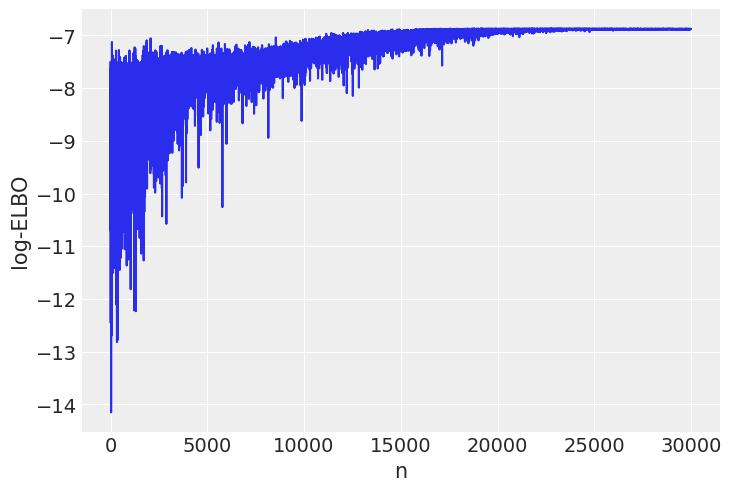

In [ ]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],1.010,0.009,0.993,1.027,0.0,0.0,10337.0,9953.0,NaN
β[1],1.230,0.008,1.215,1.246,0.0,0.0,9849.0,9753.0,NaN
α[0],0.979,0.046,0.893,1.064,0.0,0.0,9497.0,8904.0,NaN
α[1],1.362,0.048,1.276,1.457,0.0,0.0,9324.0,9480.0,NaN
𝞂[0],0.797,0.023,0.754,0.839,0.0,0.0,9608.0,9349.0,NaN


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120706 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL SIGMA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120706 (\N{MATHEMATICAL SANS-SERIF BOLD SMALL SIGMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


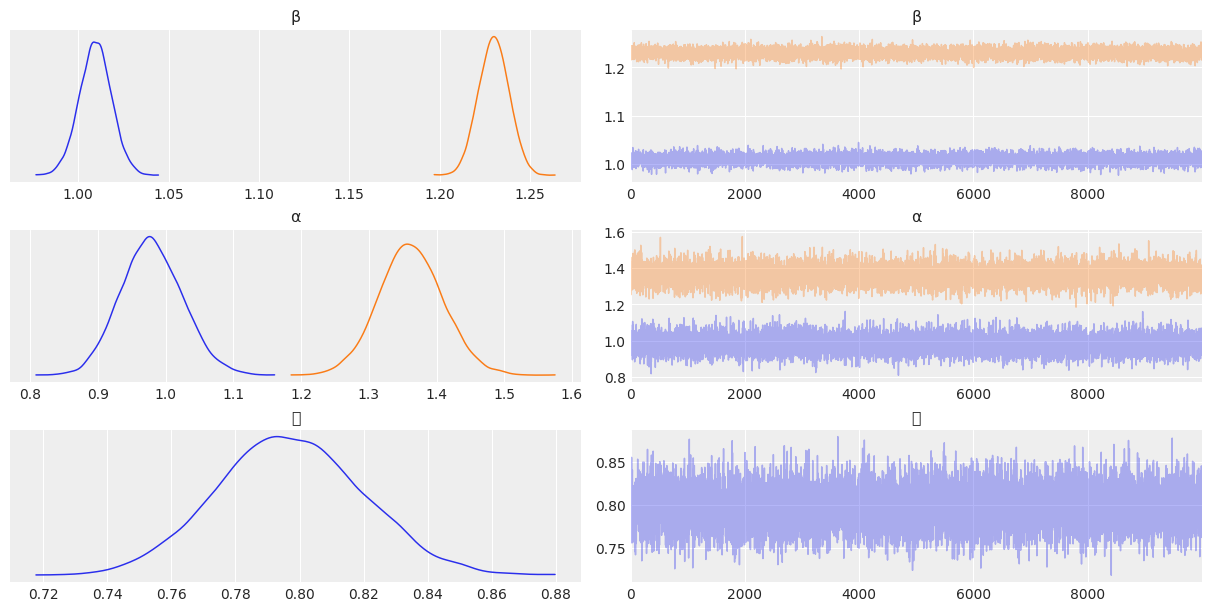

In [ ]:
advi_trace = advi_fit.sample(10000)
pm.plot_trace(advi_trace)
pm.summary(advi_trace)